# Medida de curvatura en regresión logística de alta dimensión

Usamos las **30 covariables** del dataset *Breast Cancer* para ilustrar cómo calcular la matriz de información de Fisher (curvatura) cuando la visualización 3‑D ya no es posible. Analizaremos valores propios, traza y número de condición para interpretar la precisión de los parámetros.

In [5]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns, matplotlib.pyplot as plt


In [6]:

# Cargar todas las 30 features
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Escalar
X = StandardScaler().fit_transform(X)

# Ajustar regresión logística con penalización mínima (C muy grande)
clf = LogisticRegression(max_iter=10000, C=1e6, solver='lbfgs')
clf.fit(X, y)
beta_hat = np.hstack([clf.intercept_, clf.coef_.flatten()])
print("Dimensión del parámetro:", beta_hat.shape)


Dimensión del parámetro: (31,)


In [7]:

# Calcular matriz de información de Fisher en el MLE
X_ext = np.hstack([np.ones((X.shape[0], 1)), X])  # matriz n×(d+1)
p_hat = clf.predict_proba(X)[:, 1]
W = np.diag(p_hat * (1 - p_hat))
I = X_ext.T @ W @ X_ext  # (d+1)×(d+1)

eigvals = np.linalg.eigvalsh(I)
print("Trace(I):", np.trace(I))
print("Eigenvalue min:", eigvals.min())
print("Eigenvalue max:", eigvals.max())
print("Condition number:", eigvals.max() / eigvals.min())


Trace(I): 71.43377529376475
Eigenvalue min: 4.955864171739083e-06
Eigenvalue max: 25.565303995965635
Condition number: 5158596.585788672


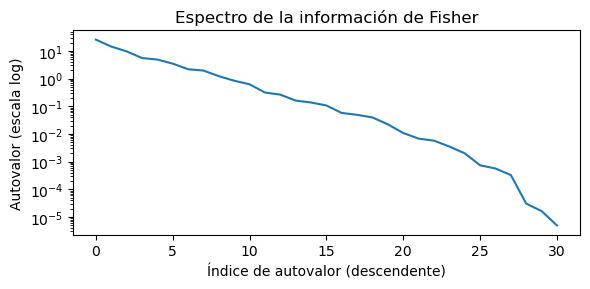

In [8]:

# Espectro de autovalores
plt.figure(figsize=(6,3))
sns.lineplot(x=np.arange(len(eigvals)), y=np.sort(eigvals)[::-1])
plt.yscale('log')
plt.xlabel('Índice de autovalor (descendente)')
plt.ylabel('Autovalor (escala log)')
plt.title('Espectro de la información de Fisher')
plt.tight_layout()
plt.show()



### 📌 Interpretación

* **Trace(I)** suma la curvatura en todas las direcciones: más grande implica datos muy informativos.
* **Valores propios pequeños** indican direcciones casi planas de la log‑verosimilitud → gran incertidumbre para esas combinaciones de parámetros.
* Un **número de condición** elevado revela un paisaje muy anisótropo: optimizadores de segunda orden pueden necesitar regularización (p. ej., damping) y los intervalos de confianza serán amplios en direcciones poco curvadas.


### 📐 Curvatura de la log-verosimilitud y autovalores de la información de Fisher

Sea $\ell(\beta)$ la log-verosimilitud de un modelo paramétrico (regresión logística, en nuestro caso).
Alrededor del estimador de máxima verosimilitud $\hat\beta$ podemos hacer una expansión de segundo orden:

$$
\ell(\beta) \;\approx\; 
\ell(\hat\beta)\;-\;\tfrac12\,
(\beta-\hat\beta)^{\!\top}
\underbrace{\bigl[-\nabla^{2}\ell(\hat\beta)\bigr]}_{\displaystyle\mathcal I(\hat\beta)}
(\beta-\hat\beta),
$$

donde
$\mathcal I(\hat\beta)= -\nabla^{2}\ell(\hat\beta)$ es **la matriz de información de Fisher**
(Hessiano negativo de $\ell$).

---

#### Descomposición espectral

La curvatura en cada dirección se analiza diagonalizando $\mathcal I(\hat\beta)$:

$$
\mathcal I(\hat\beta)\;=\; Q\,\Lambda\,Q^{\!\top},
\qquad 
\Lambda=\operatorname{diag}(\lambda_1,\dots,\lambda_p),\;
\lambda_1\!\ge\!\dots\!\ge\!\lambda_p>0,
$$

donde

* $Q$ es ortogonal (columnas = autovectores $q_j$),
* $\lambda_j$ son los **autovalores** (valores propios).

Cada par $(\lambda_j,q_j)$ interpreta la parábola local así:

$$
-\!\bigl(\beta-\hat\beta\bigr)^{\!\top} \mathcal I\,(\beta-\hat\beta)
=\;
-\sum_{j=1}^p \lambda_j\,
\bigl[(\beta-\hat\beta)^{\!\top} q_j\bigr]^2 .
$$

* **Curvatura en la dirección $q_j$** ⇢ $\lambda_j$

  * grande  $\;\Rightarrow\;$ superficie “picuda” → varianza baja en esa combinación lineal;
  * pequeña $\;\Rightarrow\;$ superficie “plana” → varianza alta (estimación inestable).




#### Medidas resumidas

* **Traza**
  $\displaystyle \operatorname{tr}\!\bigl(\mathcal I\bigr)=\sum_{j}\lambda_j$
  mide la curvatura total (información agregada).

* **Número de condición**
  $\displaystyle \kappa(\mathcal I)=\lambda_{\max}/\lambda_{\min}$
  cuantifica cuán **anisótropa** es la superficie:
  $\kappa$ grande  →  hay direcciones muy planas frente a otras muy empinadas,
  lo que dificulta optimización y produce intervalos alargados.


#### Conexión con la varianza del estimador

En modelos regulares,

$$
\operatorname{Var}(\hat\beta)\;\approx\;\mathcal I(\hat\beta)^{-1}
= Q\,\Lambda^{-1} Q^{\!\top},
$$

de modo que la **varianza en la dirección $q_j$** es $1/\lambda_j$.
Así, inspeccionar los *autovalores* ofrece una medida directa y sencilla de la precisión y estabilidad de la estimación en cada eje de parámetros.
